This notebook is helpful for looking at the iterative training process -- as you can quickly iterate between training the ridge regression and the gaussian process.

In [147]:
import os
import numpy as np
from matplotlib import pyplot as plt

# SKLEARN modules
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from scipy.interpolate import griddata

import sys
sys.path.append('../')
from src.utils import (
    load_dataset,
    create_folds,
    standardize_data,
    generate_data,
    create_weight_matrix,
)

from Datasets.spatial_dataset import SpatialDataset

In [148]:
# Print out the args
data_dir = "../data/durham/"
window_size = 25
use_coords = False
ndvi_ls = 16
albedo_ls = 7
l2_alpha = 0.1 

In [149]:
data = load_dataset(data_dir, window_size)

In [150]:
idx = range(len(data.coords))
X, y = generate_data(data, idx, ndvi_ls, albedo_ls, window_size, False)

In [151]:
# Now, we need to standardize the data for the final fit
x_shift = X.min(axis=0)
x_scale = X.max(axis=0) - X.min(axis=0)

# Add in a small number 1e-8 to prevent divide by zero errors
x_train = (X - x_shift) / (x_scale + 1e-16)

# Standardize the labels
y_mean = y.mean()
y_std = y.std()

y_train = (y - y_mean) / (y_std)

# Round 1

In [152]:
lm = Ridge(alpha=l2_alpha, fit_intercept=False).fit(x_train, y_train)
lm.coef_

array([ 0.01129126,  4.18077091,  3.01752164,  2.77219977,  0.4341774 ,
        0.05459489,  1.93564785,  2.03911426,  1.29786394, -0.24499555,
        0.21004368,  1.58750902,  0.        ,  2.17954185,  1.90738906,
       -0.52289222, -4.85435818, -0.20506466, -1.69000497])

In [153]:
pred = lm.predict(x_train)

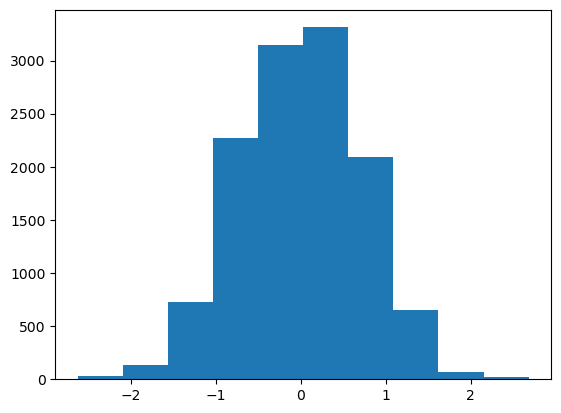

In [154]:
plt.hist(y_train - pred)
plt.show()

In [160]:
coords = data.coords

residuals = y_train - pred

N = 1000
sample_idx = np.random.choice(np.arange(coords.shape[0]), N, replace=False)
sample_points = coords[sample_idx, :]
sample_residuals = residuals[sample_idx]

In [156]:
from scipy.optimize import minimize

def optimizer(obj_func, initial_theta, bounds):

    opt_res =  minimize(obj_func, initial_theta, method='L-BFGS-B', bounds=bounds, jac=True, options = {'maxiter':1000})    

    return opt_res.x, opt_res.fun

In [157]:
kernel = (kernels.ConstantKernel(0.5, 'fixed')*kernels.Matern(length_scale=115, nu=0.5, length_scale_bounds='fixed')+ kernels.ConstantKernel(3e-7, 'fixed')*kernels.DotProduct(0.1, 'fixed'))
gpr = GaussianProcessRegressor(kernel = kernel, alpha=0.1, random_state=100, n_restarts_optimizer=10)

gpr.fit(sample_points, sample_residuals)

GaussianProcessRegressor(alpha=0.1,
                         kernel=0.707**2 * Matern(length_scale=115, nu=0.5) + 0.000548**2 * DotProduct(sigma_0=0.1),
                         n_restarts_optimizer=10, random_state=100)

In [158]:
x = np.arange(0, data.ndvi.shape[0])
y = np.arange(0, data.ndvi.shape[1])

# Get the meshgrid of the points
(x_grid, y_grid) = np.meshgrid(x, y)

# Downsample the points, by only getting every 10th point
ds = 10
x_downsample = x_grid[::ds, ::ds]
y_downsample = y_grid[::ds, ::ds]

# Stack the x and y coordinates
all_coords = np.vstack((x_downsample.flatten(), y_downsample.flatten())).T

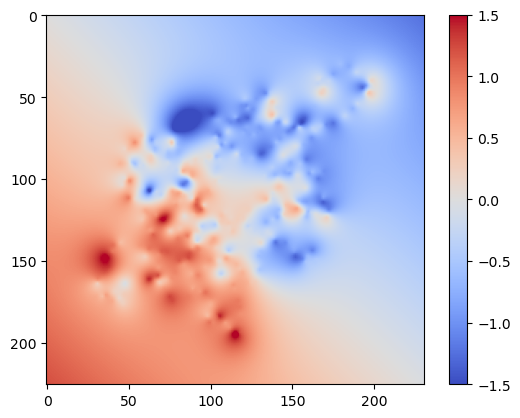

In [159]:
preds = gpr.predict(all_coords)
plt.imshow(preds.reshape(x_downsample.shape).T, cmap='coolwarm', vmin=-1.5, vmax=1.5)
plt.colorbar()

# Round 2

In [142]:
U = gpr.predict(coords)
lm2 = Ridge(alpha=l2_alpha, fit_intercept=False).fit(x_train, y_train - U)
lm2.coef_

array([ 0.43769531,  1.68466072,  1.70431068,  1.44672845,  0.27426204,
        0.27270865,  0.86018181,  0.82132192,  0.26191399,  0.04348327,
        0.18355212,  0.99550966,  0.        ,  0.69783823,  0.58760398,
       -0.20231779, -2.5325607 ,  0.13056469, -0.21766902])

In [143]:
# print out r2 score
pred = lm2.predict(x_train) #+ U
# pred_val = lm2.predict(x_val)
# print("R2 score", r2_score(y_val, pred_val ))
print("R2 score: ", r2_score(y_train, pred))

R2 score:  0.432246061766831


In [144]:
residuals = y_train - lm2.predict(x_train)

In [63]:
# coords = data.coords

N = 1000
sample_idx = np.random.choice(np.arange(coords.shape[0]), N, replace=False)
sample_points = coords[sample_idx, :]
sample_residuals = residuals[sample_idx]

In [140]:
kernel = kernels.Matern(length_scale=200, nu=2.5) + kernels.DotProduct(sigma_0_bounds=(1e-9, 1e5)) + kernels.WhiteKernel(noise_level=0.1)
gpr = GaussianProcessRegressor(kernel = kernel, optimizer=optimizer, n_restarts_optimizer=10, random_state=100)

gpr.fit(sample_points, sample_residuals)

KeyboardInterrupt: 

In [82]:
U = gpr.predict(coords)

# Round 3

In [83]:
lm3 = Ridge(alpha=l2_alpha).fit(x_train, y_train - U)
lm3.coef_

array([ 0.14090537, -0.00552736,  0.60762111,  1.16279311, -0.00759504,
        0.1866761 , -0.76485515, -0.27542925, -0.59370646, -0.63795135,
       -0.27431908,  0.14364021,  0.        , -0.74866681,  0.9739148 ,
       -0.08880165, -1.61387883,  0.06119374, -1.13128828])

In [84]:
# print out r2 score
pred = lm2.predict(x_train) + U

print("R2 score: ", r2_score(y_train, pred))

R2 score:  0.9306865556728758


In [85]:
residuals = y_train - lm3.predict(x_train)

In [86]:
N = 1000
sample_idx = np.random.choice(np.arange(coords.shape[0]), N, replace=False)
sample_points = coords[sample_idx, :]
sample_residuals = residuals[sample_idx]

In [141]:
kernel = kernels.ConstantKernel(0.5, constant_value_bounds='fixed')*kernels.Matern(length_scale=150, nu=0.5, length_scale_bounds='fixed') + kernels.DotProduct(0.001, sigma_0_bounds='fixed') #+ kernels.WhiteKernel(noise_level=0.1, noise_level_bounds='fixed')
gpr = GaussianProcessRegressor(kernel = kernel, optimizer=optimizer, n_restarts_optimizer=10, random_state=100)

gpr.fit(sample_points, sample_residuals)

print(gpr.kernel_)

0.707**2 * Matern(length_scale=150, nu=0.5) + DotProduct(sigma_0=0.001)


In [ ]:
kp = gp.kernel_.get_params()
        row.append(kp["k1__k2__length_scale"])
        row.append(kp["k2__sigma_0"])

In [142]:
U = gpr.predict(coords)

In [145]:
# Print out the r2 score of the unobserved confoundign with the residuals
print("R2 score: ", r2_score(y_train, lm3.predict(x_train) + U))
print("R2 score: ", r2_score(residuals, U))

R2 score:  0.9399819461286901
R2 score:  0.8959830121690767


# Round 4

In [146]:
lm4 = Ridge(alpha=l2_alpha).fit(x_train, y_train - U)
lm4.coef_

array([-0.51035375,  0.03337249,  0.59963991,  1.19460715,  0.07029389,
        0.11347617, -0.25886425, -0.36026959, -1.04612206, -0.29921581,
        0.06098576, -0.32962043,  0.        , -0.45706652,  0.96061247,
       -0.09067755, -1.4592849 ,  0.2424205 , -1.11471292])

In [149]:
# print out r2 score
pred = lm2.predict(x_train) + U

print("R2 score: ", r2_score(y_train, pred))

R2 score:  0.9449552448434786


In [91]:
residuals = y_train - lm4.predict(x_train)

In [92]:
N = 1000
sample_idx = np.random.choice(np.arange(coords.shape[0]), N, replace=False)
sample_points = coords[sample_idx, :]
sample_residuals = residuals[sample_idx]

In [93]:
kernel = kernels.Matern(length_scale=200, nu=2.5) + kernels.DotProduct(sigma_0_bounds=(1e-9, 1e5)) + kernels.WhiteKernel(noise_level=0.1)
gpr = GaussianProcessRegressor(kernel = kernel, optimizer=optimizer, n_restarts_optimizer=10, random_state=100)

gpr.fit(sample_points, sample_residuals)

print(gpr.kernel_)

Matern(length_scale=42.7, nu=2.5) + DotProduct(sigma_0=0.772) + WhiteKernel(noise_level=0.0109)


In [94]:
U = gpr.predict(coords)

(array([  31.,   84.,  564., 1759., 2955., 3520., 2455.,  975.,   82.,
          23.]),
 array([-2.78720085, -2.24977393, -1.71234701, -1.17492008, -0.63749316,
        -0.10006624,  0.43736069,  0.97478761,  1.51221453,  2.04964146,
         2.58706838]),
 <BarContainer object of 10 artists>)

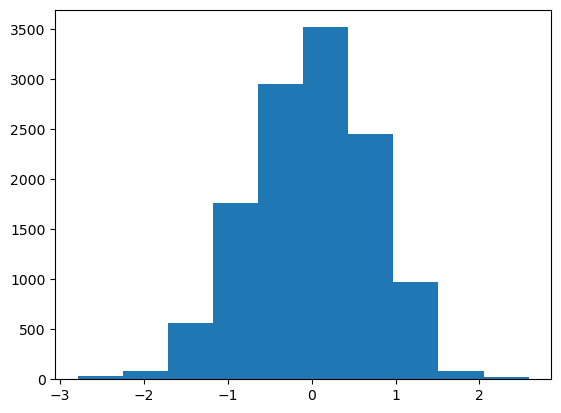

In [95]:
plt.hist(U)

In [96]:
print(sum(lm.coef_**2))
print(sum(lm2.coef_**2))
print(sum(lm3.coef_**2))
print(sum(lm4.coef_**2))

14.591326022694178
11.034104557870432
8.697359665292911
9.010579578744922


In [100]:
print(lm.coef_)
print(lm4.coef_)

[-0.2214845   0.15600338  0.56699545  1.08222051 -0.38373892 -0.20304431
 -0.12345529 -0.26765037 -0.90016522 -0.45260183 -0.46204946  0.03920232
  0.         -0.42057039  1.50473644 -0.29654673 -2.38799483  0.16669024
 -1.80564658]
[ 0.28888392 -0.02396904  0.54298637  1.16007102  0.1486272   0.22928664
 -0.62094103 -0.39059182 -0.66091748 -0.80058993 -0.16747365  0.07742262
  0.         -0.81855665  1.38643627 -0.04661309 -1.40643307  0.06474142
 -0.99232226]


In [101]:
lm4.intercept_

0.7527304038472126

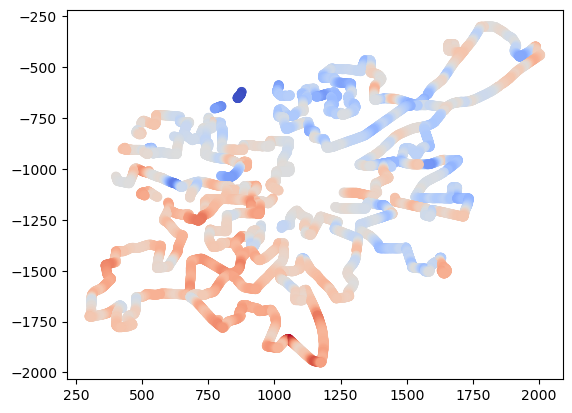

In [97]:
plt.scatter(coords[:, 1], -coords[:, 0], c=U, cmap='coolwarm')

# Flip y coordinate


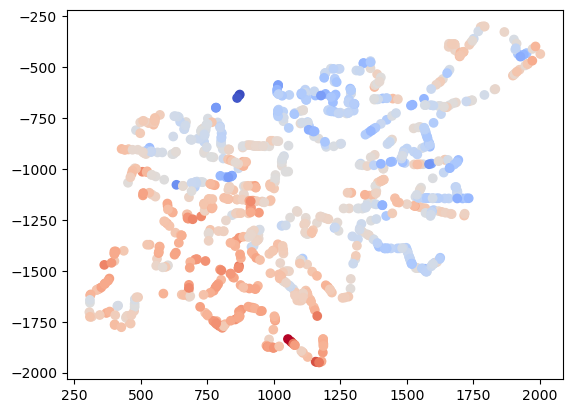

In [98]:
plt.scatter(sample_points[:, 1], -sample_points[:, 0], c=sample_residuals, cmap='coolwarm')